In [1]:
cd /content/drive/MyDrive/Colab Notebooks


/content/drive/MyDrive/Colab Notebooks


In [2]:
!unzip intel.zip


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain/7693.jpg  
  inflating

In [3]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
from keras import regularizers
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.attention.multi_head_attention import regularization
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Conv3D, AveragePooling2D, Activation, Add
from keras.layers import Dense, Flatten, Dropout, BatchNormalization, Concatenate
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from keras import Input
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.optimizers import SGD
from keras.optimizers import Adam


In [5]:
img_gen = ImageDataGenerator(rescale=1./255)

In [6]:
train_loader = img_gen.flow_from_directory(
    directory="seg_train/seg_train", 
    target_size=(128,128),
    batch_size=64,
    seed=42
)

Found 14034 images belonging to 6 classes.


In [7]:
test_loader = img_gen.flow_from_directory(
    directory="seg_test/seg_test", 
    target_size=(128,128),
    batch_size=64,
    seed=42
)

Found 3000 images belonging to 6 classes.


In [8]:
train_loader.class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [9]:
idx_to_classes={val:key for key,val in train_loader.class_indices.items()}

In [10]:
print(idx_to_classes)

{0: 'buildings', 1: 'forest', 2: 'glacier', 3: 'mountain', 4: 'sea', 5: 'street'}


In [11]:
print(train_loader)

In [ ]:
# print(train_loader.shape)

In [26]:
def bottleneck_residual_block (X, filters, strides, reduce=False) :
  f1,f2,f3 = filters

  X_shortcut = X

  # 잔차블록 첫번째 층
  # shortcut on;
  if reduce == True :
    # 잔차블록 층에서 나중에 합해줄 shortcut 부분 할당
    X_shortcut = Conv2D(filters= f3, kernel_size = 1, strides= strides)(X_shortcut)
    X_shortcut = BatchNormalization(axis=3)(X_shortcut)
    
    # 
    X = Conv2D(filters = f1, kernel_size =1, strides=strides, padding='same')(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
  
  # shortcut off;
  else :
    X = Conv2D(filters = f1, kernel_size =1, strides=1, padding='same')(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

  # 두번째 층
  X = Conv2D(filters = f2, kernel_size =3, strides=1, padding='same')(X)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)

  # 세번째 층
  X = Conv2D(filters = f3, kernel_size =1, strides=1, padding='same')(X)
  X = BatchNormalization(axis=3)(X)
  

  # 마지막 잔차 블록 합
  X = Add()([X, X_shortcut])
  X = Activation('relu')(X)

  return X



In [27]:
def ResNet50(input_layer) :
  Input(shape=(input_layer))

  # 1단계

  X = Conv2D(64, kernel_size=7, strides=2, padding='same')(input_layer)
  # print(X.shape)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)
  X = MaxPooling2D(3, strides=2, padding='same')(X)
  # print(X.shape)


  # 2단계 

  X = bottleneck_residual_block(X,(64,64,256), strides=1, reduce=True)
  X = bottleneck_residual_block(X,(64,64,256), strides=1)
  X = bottleneck_residual_block(X,(64,64,256), strides=1)


  # 3단계 

  X = bottleneck_residual_block(X,(128,128,512), strides=2, reduce=True)
  X = bottleneck_residual_block(X,(128,128,512), strides=1)
  X = bottleneck_residual_block(X,(128,128,512), strides=1)
  X = bottleneck_residual_block(X,(128,128,512), strides=1)


  # 4단계 

  X = bottleneck_residual_block(X,(256,256,1024), strides=2, reduce=True)
  X = bottleneck_residual_block(X,(256,256,1024), strides=1)
  X = bottleneck_residual_block(X,(256,256,1024), strides=1)
  X = bottleneck_residual_block(X,(256,256,1024), strides=1)
  X = bottleneck_residual_block(X,(256,256,1024), strides=1)
  X = bottleneck_residual_block(X,(256,256,1024), strides=1)



  # 5단계 

  X = bottleneck_residual_block(X,(512,512,2048), strides=2, reduce=True)
  X = bottleneck_residual_block(X,(512,512,2048), strides=1)
  X = bottleneck_residual_block(X,(512,512,2048), strides=1)

  # 평균 풀링

  X = AveragePooling2D((1,1))(X)

  # 출력층

  X = Flatten()(X)
  X = Dense(1000,activation = 'softmax')(X)

  return X

In [19]:
X.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

NameError: ignored

In [25]:
hist = model.fit(train_loader,
                 batch_size=32,
                 epochs=20, 
                 validation_data=(test_loader), 
                 verbose=2, shuffle = True)

SyntaxError: ignored

In [21]:
input = (150,150,3)

In [34]:
ResNet50(input)

ValueError: ignored

In [ ]:

(x_train, y_train), (x_test, y_test) = cifar10.load_data() # x가 rgb를 포함한 data, y가 label data
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

(x_train, x_valid) = x_train[5000:], x_train[:5000]
(y_train, y_valid) = y_train[5000:], y_train[:5000]

print(x_train.shape) 
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)
print(x_test.shape)
print(y_test.shape)

x_train = (x_train - mean) / (std + 1e-7)
x_valid =(x_valid - mean) / (std + 1e-7)
x_test = (x_test - mean) / (std + 1e-7)
num_classes = len(np.unique(y_train))
y_train = to_categorical(y_train, num_classes) #to_categorical ==> one-hot encoding
y_valid = to_categorical(y_valid, num_classes)
y_test = to_categorical(y_test, num_classes)

----

Kaggle data 로 모델 직접 구현해보기

In [12]:
 model3 = Sequential()

 model3.add(Conv2D(filters=8, kernel_size=3, padding='same',  activation='relu', input_shape =(128,128,3)))
 model3.add(MaxPooling2D(pool_size=2))
 model3.add(BatchNormalization())
 model3.add(Dropout(0.5))
 model3.add(Conv2D(filters=16, kernel_size=5,padding='same', activation='relu'))
 model3.add(MaxPooling2D(pool_size=2))
 model3.add(BatchNormalization())
 model3.add(Dropout(0.5))



 model3.add(Flatten())

 model3.add(Dense(16,activation="relu"))
 model3.add(Dropout(0.5))
 model3.add(Dense(6,activation="softmax"))


In [13]:
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 8)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 8)        32        
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 64, 64, 8)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 16)        3216      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 16)       0

In [32]:
# model3.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [38]:
# hist = model3.fit(train_loader,
#                  batch_size=128,
#                  epochs=20, 
#                  validation_data=(test_loader), 
#                  verbose=2, shuffle = True)

RuntimeError: ignored

In [20]:
def lr_schedule(epoch) :
  if epoch <= 2:
    lr = 5e-4
  elif epoch > 2 and epoch <= 5 :
    lr = 2e-4
  elif epoch > 5 and epoch <= 9 :
    lr = 5e-5
  else :
    lr = 1e-5
  return lr

In [21]:
lr_scheduler = LearningRateScheduler(lr_schedule)
checkpoint = ModelCheckpoint(filepath='path_to_save_file/file3.hdf5',
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True)

callbacks = [checkpoint, lr_scheduler]
optimizer = Adam(lr=0.0001, decay =1e-6)

In [22]:
model3.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [23]:
hist3 = model3.fit(train_loader, epochs=20, validation_data=(test_loader), callbacks = callbacks, verbose=2, shuffle = True)

Epoch 1/20

Epoch 1: val_accuracy improved from -inf to 0.19367, saving model to path_to_save_file/file3.hdf5
220/220 - 36s - loss: 1.6063 - accuracy: 0.3779 - val_loss: 6.1960 - val_accuracy: 0.1937 - lr: 5.0000e-04 - 36s/epoch - 164ms/step
Epoch 2/20

Epoch 2: val_accuracy improved from 0.19367 to 0.44900, saving model to path_to_save_file/file3.hdf5
220/220 - 29s - loss: 1.3489 - accuracy: 0.4639 - val_loss: 2.6167 - val_accuracy: 0.4490 - lr: 5.0000e-04 - 29s/epoch - 132ms/step
Epoch 3/20

Epoch 3: val_accuracy improved from 0.44900 to 0.48867, saving model to path_to_save_file/file3.hdf5
220/220 - 30s - loss: 1.2589 - accuracy: 0.5039 - val_loss: 2.1280 - val_accuracy: 0.4887 - lr: 5.0000e-04 - 30s/epoch - 135ms/step
Epoch 4/20

Epoch 4: val_accuracy improved from 0.48867 to 0.51333, saving model to path_to_save_file/file3.hdf5
220/220 - 29s - loss: 1.1995 - accuracy: 0.5242 - val_loss: 1.6747 - val_accuracy: 0.5133 - lr: 2.0000e-04 - 29s/epoch - 131ms/step
Epoch 5/20

Epoch 5: va

In [28]:
train_loss=hist3.history['loss']
train_acc=hist3.history['accuracy']
test_loss=hist3.history['val_loss']
test_acc=hist3.history['val_accuracy']

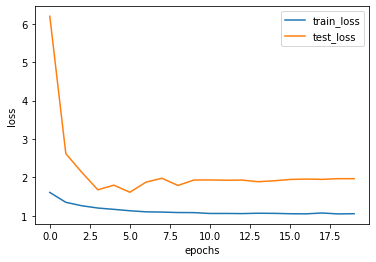

In [29]:
plt.plot(range(20), train_loss, label='train_loss')
plt.plot(range(20), test_loss, label='test_loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

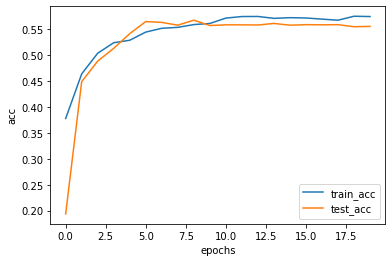

In [30]:
plt.plot(range(20), train_acc, label='train_acc')
plt.plot(range(20), test_acc, label='test_acc')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.legend()

In [31]:
import os

In [32]:
pred_list = [f"seg_pred/seg_pred/{i}" for i in os.listdir("seg_pred/seg_pred")]

In [33]:
pred_list[0]

'seg_pred/seg_pred/7104.jpg'

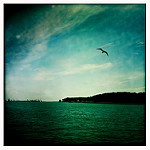

In [107]:
img = Image.open(pred_list[7])
display(img)

In [108]:
img=img.resize((128,128))

In [109]:
img_arr =np.array(img)

In [110]:
img_arr = img_arr[np.newaxis, :]

In [111]:
img_arr = img_arr.astype('float')

In [112]:
img_arr = img_gen.standardize(img_arr)

In [113]:
probability = model3(img_arr)

In [114]:
pred = np.argmax(probability)

In [115]:
idx_to_classes[pred]

'glacier'